## Importando bibliotecas

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

## Importando dados

Transformações realizadas:

* `ano_modelo` e `num_fotos`: alterados para `int`;
* `dono_aceita_troca`, `veiculo_único_dono`, `revisoes_concessionaria`, `ipva_pago`, `veiculo_licenciado`,
`garantia_de_fábrica`, `revisoes_dentro_agenda`, `blindado`: alterados para booleanos (1 ou 0);
* `veiculo_alienado` e `elegivel_revisao`: removidos pois todas as observações são iguais;
* `tipo_vendedor`: alterado para `vendedor_PJ` e transformado em booleano.

In [131]:
# Ler dados de treino
df = pd.read_csv('./dataset/cars_train.csv', sep='\t', encoding='utf_16')

# Transformar para inteiro
df['ano_modelo'] = df.ano_modelo.astype(int)
df['num_fotos'] = df.num_fotos.fillna(0).astype(int)

# Transformar em booleanos
df['dono_aceita_troca'] = df.dono_aceita_troca.notnull().astype(int)
df['veiculo_único_dono'] = df.veiculo_único_dono.notnull().astype(int)
df['revisoes_concessionaria'] = df.revisoes_concessionaria.notnull().astype(int)
df['ipva_pago'] = df.ipva_pago.notnull().astype(int)
df['veiculo_licenciado'] = df.veiculo_licenciado.notnull().astype(int)
df['garantia_de_fábrica'] = df.garantia_de_fábrica.notnull().astype(int)
df['revisoes_dentro_agenda'] = df.revisoes_dentro_agenda.notnull().astype(int)
df['entrega_delivery'] = df.entrega_delivery.astype(int)
df['troca'] = df.troca.astype(int)
df['blindado'] = df.blindado.map({'N': 0, 'S': 1})

# Colunas descartadas
df.drop(columns=['veiculo_alienado'], inplace=True)
df.drop(columns=['elegivel_revisao'], inplace=True)

# Remapeando tipo_vendedor e alterando o nome da variável
df['tipo_vendedor'] = df.tipo_vendedor.map({'PJ': 1, 'PF': 0})
df.rename(columns={'tipo_vendedor':'vendedor_PJ'}, inplace=True)

## Modelos

Para os modelos de Machine Learning, iremos treinar um modelo base e iremos usar seus resultados como benchmark e compará-los com os demais.

Para modelos lineares estaremos utilizando o `StandardScaler` para escalonar os dados, uma vez que esse tipo de algoritmo de Machine Learning é sensível à dados que não estão em escala. 

Para avaliar os testes realizados, faremos uso de um K-Fold com 5 splits, e avaliaremos os scores obtidos pelo modelo.

Quanto as métricas utilizadas, optamos pelo R² e pelo RMSE (raiz do erro quadrático médio). O R² é uma medida de 0 a 1 que expressa a quantidade da variância dos dados, já o RMSE é a raiz da soma dos quadrados dos erros, e tem a vantagem de estar na mesma unidade de medida que o próprio target (neste caso R$).

### Modelo 1 - Regressão linear

O primeiro modelo que testaremos será o de regressão linear. Isso porque esse algoritmo é um dos mais simples e tem uma boa interpretabilidade dos resultados.

Porém, devemos nos atentar com as variáveis categóricas. A princípio, vamos transformar as features `tipo`, `cambio`, `cor` e `anunciante` em dummies, removendo o primeiro valor de cada (drop_first), a fim de evitar problemas de colinearidade.

In [132]:
df1 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True)

X = df1.select_dtypes(np.number).drop(columns=['preco'])
y = df1.preco

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo1 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

r2_scores = cross_val_score(modelo1, X, y, cv=kfold, scoring='r2')
rmse_scores = cross_val_score(modelo1, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print('Scores do CV (R2):', r2_scores)
print('Média (R2):', r2_scores.mean().round(2))
print('Scores do CV (RMSE):', rmse_scores)
print('Média (RMSE):', rmse_scores.mean().round(2))

Scores do CV (R2): [0.45678729 0.40996232 0.42214345 0.42260468 0.42376281]
Média (R2): 0.43
Scores do CV (RMSE): [-58828.17350452 -67187.72554676 -59904.56294866 -61582.28098774
 -61364.8289622 ]
Média (RMSE): -61773.51


Vamos armazenar os resultados dos modelos em um data frame para comparar suas performances.

In [133]:
modelos = pd.DataFrame([{'modelo': 'LinearRegression', 
                        'r2_score': r2_scores.mean().round(3), 
                        'rmse_score': rmse_scores.mean().round(2)}])
modelos

,modelo,r2_score,rmse_score
0,LinearRegression,0.427,-61773.51


A seguir um gráfico que compara os valores preditos e valores reais dos preços dos veículos.

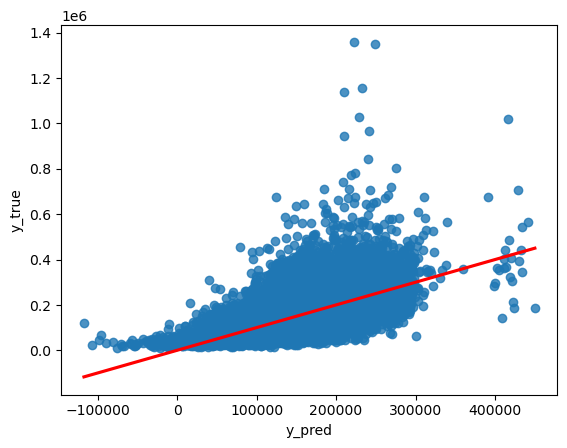

In [134]:
y_pred1 = modelo1.fit(X, y).predict(X)
sns.regplot(x=y_pred1, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

As categorias dropadas pelo `drop_first` foram as seguintes:

In [135]:
set(pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'])) - set(pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True).columns)

{'anunciante_Acessórios e serviços para autos',
 'cambio_Automatizada',
 'cor_Branco',
 'tipo_Cupê'}

A seguir um gráfico que mostra a importância de cada uma das variáveis.

num_fotos                         6201.452796
ano_de_fabricacao                11576.670320
ano_modelo                       -4523.483629
hodometro                       -23481.899578
num_portas                       -4933.633473
blindado                          4240.194366
vendedor_PJ                      -8386.550846
entrega_delivery                 -1515.255149
troca                             1472.643735
dono_aceita_troca                13394.485836
veiculo_único_dono               -4678.032495
revisoes_concessionaria           9549.428729
ipva_pago                        -1733.851936
veiculo_licenciado                -176.380521
garantia_de_fábrica                248.533761
revisoes_dentro_agenda            -265.045454
tipo_Hatchback                  -89515.106488
tipo_Minivan                     -4170.901214
tipo_Perua/SW                    -6341.106876
tipo_Picape                     -69589.036400
tipo_Sedã                      -116916.212883
tipo_Utilitário esportivo       -4

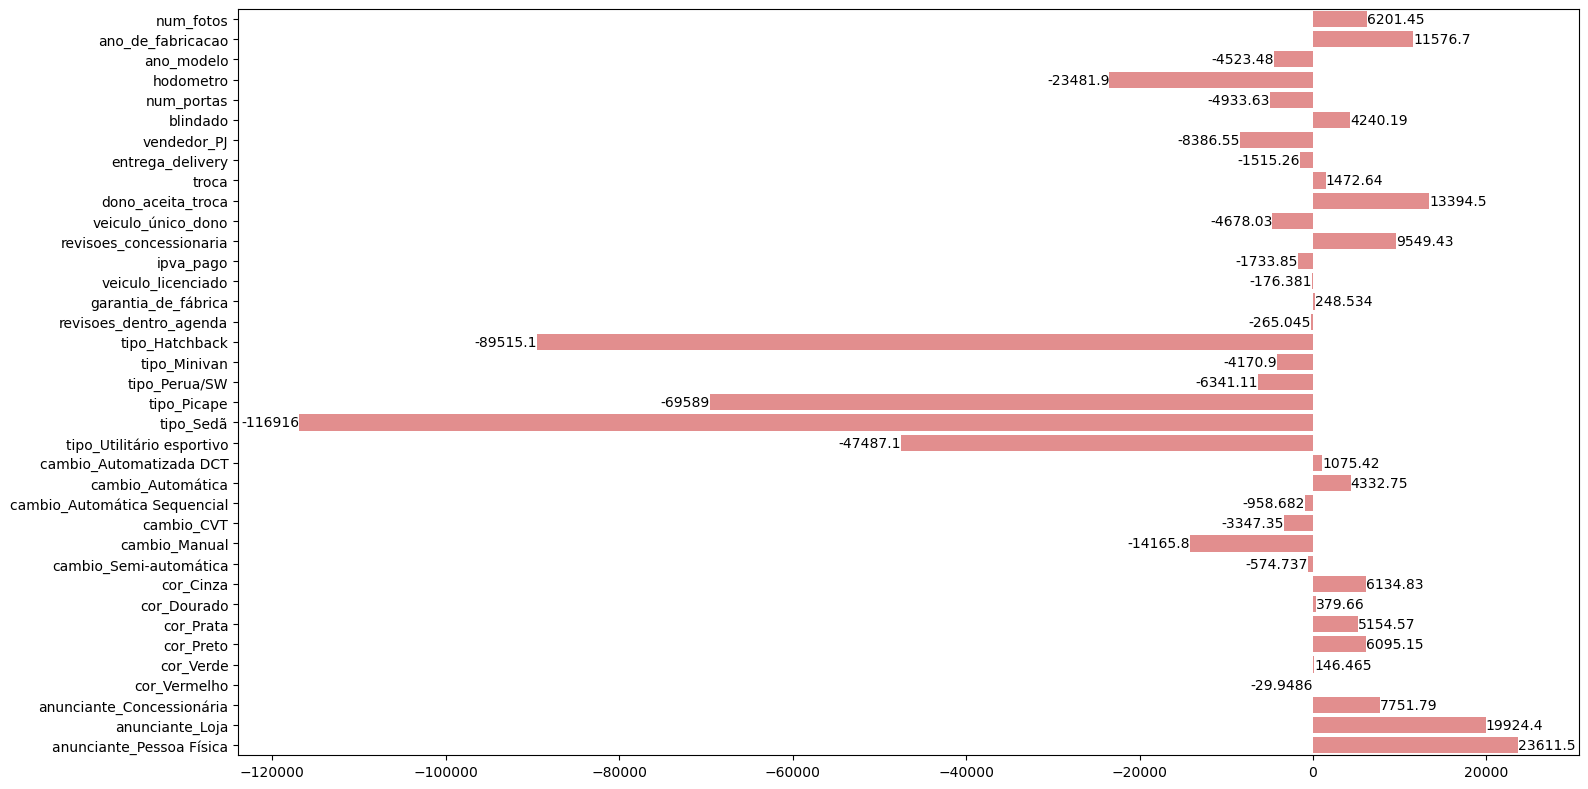

In [136]:
coef = modelo1.named_steps['regressor'].coef_

display(pd.Series(data=coef, index=X.columns))

plt.figure(figsize=(16, 8))
ax = sns.barplot(y=X.columns, x=coef, color='lightcoral')
ax.bar_label(ax.containers[0])
ax.figure.tight_layout()
plt.show()

Pelos resultados obtidos do modelo, os coeficientes que mais estão impactando na predição do preço estão relacionadas ao tipo de veículo.

### Modelo 2

O segundo modelo que iremos avaliar é o Ridge. O algoritmo se trata de uma extensão da regressão lienar, introduzindo um coeficiente de regularização (L2). Esse tipo de regressão ajuda a mitigar os efeitos de multicolinearidade reduzindo o impacto de variáveis altamente correlacionadas.

In [137]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

modelo2 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

grid_search = GridSearchCV(modelo2, 
                           param_grid={'regressor__alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
                           cv=kfold,
                           scoring=['r2', 'neg_root_mean_squared_error'],
                           refit='r2')

r2_scores = cross_val_score(grid_search, X, y, cv=kfold, scoring='r2')
rmse_scores = cross_val_score(grid_search, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print('Scores do CV (R2):', r2_scores)
print('Média (R2):', r2_scores.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores)
print('Média (RMSE):', rmse_scores.mean().round(2))

Scores do CV (R2): [0.4567265  0.4114817  0.42222797 0.42108706 0.42376195]
Média (R2): 0.427
Scores do CV (RMSE): [-58831.46523399 -67101.16374099 -59900.18153324 -61663.15889343
 -61364.87460491]
Média (RMSE): -61772.17


In [138]:
modelos = pd.concat(
    [modelos, 
     pd.DataFrame([{'modelo': 'Ridge', 
                    'r2_score': r2_scores.mean().round(3), 
                    'rmse_score': rmse_scores.mean().round(2)}])
    ]
)
modelos

,modelo,r2_score,rmse_score
0,LinearRegression,0.427,-61773.51
0,Ridge,0.427,-61772.17


In [ ]:
df3 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True)
df3['marca'] = df3['marca'].astype('category').cat.codes
# df3['combustivel'] = df3['combustivel'].astype('category').cat.codes
df3['modelo'] = df3['modelo'].astype('category').cat.codes
df3['versao'] = df3['versao'].astype('category').cat.codes
df3['estado_vendedor'] = df3['estado_vendedor'].astype('category').cat.codes
df3.drop(columns='cidade_vendedor', inplace=True)


# from sklearn.compose import ColumnTransformer

X = df3.drop(columns=['preco', 'id'])
y = df3.preco

cat_cols = X.select_dtypes('object').columns.tolist()
# encoder = OrdinalEncoder()
# encoder.fit_transform(X)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', OrdinalEncoder(), cat_cols)
#     ]
# )

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    # ('encoder', OneHotEncoder(categories='auto', drop='first')),
    # ('encoder', LabelEncoder()),
    # ('encoder', OrdinalEncoder()),
    # ('preprocessor', preprocessor),
    # ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=31))
    # ('regressor', LinearRegression())
])

# from sklearn.model_selection import GridSearchCV
# grid_CV = GridSearchCV(pipeline, )

scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
print(scores)

y_pred3 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred3, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

Vamos realizar feature engineering para extrair informações presentes na coluna de versão do carro.

In [ ]:
# df[~df.versao.str.slice(0,1).str.isdigit()]

In [ ]:
# os 3 primeiros digitos referem-se as cilindradas do motor
# para os carros elétricos, que não tem essa identificação, o motor foi considerado como igual a 0

import re
df['motor'] = df.versao.str.slice(0, 3).apply(lambda x: float(x) if re.findall('^\d\.\d$', x) else 0.0)

In [ ]:
# df[df['versao'].str.slice(0,3).str.match(r'^\d\.\d$')].sort_values('versao').versao.unique()

In [ ]:
combustivel = df.versao.apply(lambda car: 'gasolina' if re.findall('GAS', car) else \
                ('flex' if re.findall('FLEX|TETRAFUEL', car) else \
                ('diesel' if re.findall('DIESEL', car) else \
                ('eletrico' if re.findall('ELETRI|ELÉTRI|ELECTRI|RECHARG', car) else \
                ('hibrido' if re.findall('HÍBRID|HYBRID|HIBRID', car) else \
                ('flex' if re.findall('1\.', car) else 'gasolina')))))) # carros da volkswagen que são flex
df['combustivel'] = combustivel

In [ ]:
df['4x4'] = df.versao.str.contains('4X4')
df['turbo'] = df.versao.str.contains('TURBO')


In [ ]:
display(
    df.groupby('motor').preco.mean(), 
    df.groupby('combustivel').preco.mean(), 
    df.groupby('4x4').preco.mean(), 
    df.groupby('turbo').preco.mean()
)

In [ ]:
# plt.figure(figsize=(5, 10))
# sns.boxplot(df, y='motor', x='preco')
# plt.show()

colunas_novas_features = ['combustivel', '4x4', 'turbo']

for feature in colunas_novas_features:
    plt.figure(figsize=(5, 5))
    sns.boxplot(df, x=feature, y='preco')
    plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(df, x='motor', y='preco')
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['motor'].astype(int), y=df['preco'])
plt.show()

In [ ]:
# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df4 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df4.select_dtypes(np.number).drop(columns=['preco'])
y = df4.preco

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

print('Scores do CV (R2):', cross_val_score(pipeline, X, y, cv=kfold, scoring='r2'))
print('Média (R2):', cross_val_score(pipeline, X, y, cv=kfold, scoring='r2').mean().round(2))
print('Scores do CV (RMSE):', cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_root_mean_squared_error'))
print('Média (RMSE):', cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_root_mean_squared_error').mean().round(2))

y_pred4 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred4, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()


In [ ]:
pipeline.fit(X, y)
{feat: value for feat, value in zip(X.columns, pipeline.named_steps['regressor'].coef_)}

In [ ]:
# df5 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True)
# df5 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)
df5 = df.copy()
df5['tipo'] = df5['tipo'].astype('category').cat.codes
df5['cambio'] = df5['cambio'].astype('category').cat.codes
df5['cor'] = df5['cor'].astype('category').cat.codes
df5['anunciante'] = df5['anunciante'].astype('category').cat.codes
df5['combustivel'] = df5['combustivel'].astype('category').cat.codes
df5['marca'] = df5['marca'].astype('category').cat.codes
df5['modelo'] = df5['modelo'].astype('category').cat.codes
df5['versao'] = df5['versao'].astype('category').cat.codes
df5['estado_vendedor'] = df5['estado_vendedor'].astype('category').cat.codes
df5.drop(columns='cidade_vendedor', inplace=True)


# from sklearn.compose import ColumnTransformer

X = df5.drop(columns=['preco', 'id'])
y = df5.preco

cat_cols = X.select_dtypes('object').columns.tolist()
# encoder = OrdinalEncoder()
# encoder.fit_transform(X)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', OrdinalEncoder(), cat_cols)
#     ]
# )

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    # ('encoder', OneHotEncoder(categories='auto', drop='first')),
    # ('encoder', LabelEncoder()),
    # ('encoder', OrdinalEncoder()),
    # ('preprocessor', preprocessor),
    # ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=31))
    # ('regressor', LinearRegression())
])

# from sklearn.model_selection import GridSearchCV
# grid_CV = GridSearchCV(pipeline, )

scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
print(scores)

y_pred5 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred5, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [ ]:
# df6 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True)
# df6 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)
df6 = df.copy()
df6['tipo'] = df6['tipo'].astype('category').cat.codes
df6['cambio'] = df6['cambio'].astype('category').cat.codes
df6['cor'] = df6['cor'].astype('category').cat.codes
df6['anunciante'] = df6['anunciante'].astype('category').cat.codes
df6['combustivel'] = df6['combustivel'].astype('category').cat.codes
df6['marca'] = df6['marca'].astype('category').cat.codes
df6['modelo'] = df6['modelo'].astype('category').cat.codes
# df6['versao'] = df6['versao'].astype('category').cat.codes
df6.drop(columns='versao', inplace=True)
df6['estado_vendedor'] = df6['estado_vendedor'].astype('category').cat.codes
df6.drop(columns='cidade_vendedor', inplace=True)


# from sklearn.compose import ColumnTransformer

X = df6.drop(columns=['preco', 'id'])
y = df6.preco

cat_cols = X.select_dtypes('object').columns.tolist()
# encoder = OrdinalEncoder()
# encoder.fit_transform(X)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', OrdinalEncoder(), cat_cols)
#     ]
# )

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    # ('encoder', OneHotEncoder(categories='auto', drop='first')),
    # ('encoder', LabelEncoder()),
    # ('encoder', OrdinalEncoder()),
    # ('preprocessor', preprocessor),
    # ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=31))
    # ('regressor', LinearRegression())
])

# from sklearn.model_selection import GridSearchCV
# grid_CV = GridSearchCV(pipeline, )

scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
print(scores)


y_pred6 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred6, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [ ]:
cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

In [ ]:
from sklearn.linear_model import RidgeCV

# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df7 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df7.select_dtypes(np.number).drop(columns=['preco'])
y = df7.preco

# kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas=(0.1, 1.0, 10.0), cv=5))
])

print('Scores do CV (R2):', cross_val_score(pipeline, X, y, scoring='r2'))
print('Média (R2):', cross_val_score(pipeline, X, y, scoring='r2').mean().round(2))
print('Scores do CV (RMSE):', cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error'))
print('Média (RMSE):', cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error').mean().round(2))

y_pred7 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred7, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()


In [ ]:
from sklearn.linear_model import ElasticNetCV

# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df8 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df8.select_dtypes(np.number).drop(columns=['preco'])
y = df8.preco

# kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNetCV(cv=5))
])

print('Scores do CV (R2):', cross_val_score(pipeline, X, y, scoring='r2'))
print('Média (R2):', cross_val_score(pipeline, X, y, scoring='r2').mean().round(2))
print('Scores do CV (RMSE):', cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error'))
print('Média (RMSE):', cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error').mean().round(2))

y_pred8 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred8, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()


In [ ]:
from sklearn.neural_network import MLPRegressor

# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df9 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df9.select_dtypes(np.number).drop(columns=['preco'])
y = df9.preco

# kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MLPRegressor())
])

print('Scores do CV (R2):', cross_val_score(pipeline, X, y, scoring='r2'))
print('Média (R2):', cross_val_score(pipeline, X, y, scoring='r2').mean().round(2))
print('Scores do CV (RMSE):', cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error'))
print('Média (RMSE):', cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error').mean().round(2))

y_pred9 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred9, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()


In [ ]:
df10 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True)
df10['marca'] = df10['marca'].astype('category').cat.codes
# df10['combustivel'] = df10['combustivel'].astype('category').cat.codes
df10['modelo'] = df10['modelo'].astype('category').cat.codes
df10['versao'] = df10['versao'].astype('category').cat.codes
df10['estado_vendedor'] = df10['estado_vendedor'].astype('category').cat.codes
df10.drop(columns='cidade_vendedor', inplace=True)


# from sklearn.compose import ColumnTransformer

X = df10.drop(columns=['preco', 'id'])
y = df10.preco.apply(np.log10)

cat_cols = X.select_dtypes('object').columns.tolist()
# encoder = OrdinalEncoder()
# encoder.fit_transform(X)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', OrdinalEncoder(), cat_cols)
#     ]
# )

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

pipeline = Pipeline([
    # ('encoder', OneHotEncoder(categories='auto', drop='first')),
    # ('encoder', LabelEncoder()),
    # ('encoder', OrdinalEncoder()),
    # ('preprocessor', preprocessor),
    # ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=31))
    # ('regressor', LinearRegression())
])

# from sklearn.model_selection import GridSearchCV
# grid_CV = GridSearchCV(pipeline, )

scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
print(scores)

y_pred10 = pipeline.fit(X, y).predict(X)
sns.regplot(x=y_pred10, y=y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [ ]:
sns.regplot(x=10 ** y_pred10, y=10 ** y, line_kws={'color': 'red'})
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()